# Changes:
1. Based on V36.1
2. Use grouped optimizer
3. Use more data aug

## Install required packages if running on google colab

In [0]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

In [2]:
cd salt_oil

/content/salt_oil


## Import required libs

In [0]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import random
import PIL
import cv2 as cv
% matplotlib inline
% load_ext autoreload
% autoreload 2

## Load Unet Modules

In [0]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.unet.resnet import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch

In [0]:
## Setup data type based on whether GPU is enabled

In [6]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor
print(f'Data Type set to: {dtype}')

Data Type set to: <class 'torch.cuda.FloatTensor'>


In [0]:
def setup_train(config_list):
    for conf in config_list:
        log.info(conf)
    for conf in config_list:
        exec(conf)

## Create Logger

In [0]:
global log
log = get_logger('salt_model_v36.1_resnet_0.82_test3')

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [11]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

Try loading data from npy and pickle files...
Data loaded.


### Train Val data split

In [0]:
df_train_mask = pd.DataFrame((np_train_all_mask/255).sum((1,2,3)), columns=['mask_pix'])
df_train_mask.mask_pix = df_train_mask.mask_pix.round(-2)

X_train_ids, X_val_ids = (
    train_test_split(df_train_mask.index.tolist(), 
                     test_size=0.20,
                     stratify = df_train_mask.mask_pix,
                     random_state=0)
)

X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)
#set mean image to 0 as mean is now being handled within the model.
X_train_mean_img = np.zeros_like(X_train_mean_img)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': X_train_mean_img
}

assert X_train_mean_img == np.array([0.])
assert X_train.shape == (3200, 101, 101, 1)
assert y_train.shape == (3200, 101, 101, 1)
assert depth_train.shape == (3200, 1)

## Train the model using a small data set to see if it can overfit

In [0]:
data_loader_config = '''
train_data_params = {'batch_size': 2, 'shuffle': True,}
val_data_params = {'batch_size': 2, 'shuffle': True,}
train_dataLoader  = (
    DataLoader(SaltDataset(X_train[:4], y_train[:4], depth_train[:4],
                           X_train_mean_img, out_size=128, out_ch=1,
                           transform=None), **train_data_params)
                           #transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:4], y_val[:4], depth_val[:4], 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

'''

In [0]:
model_config = '''
saltnet = UResNet(pretrained=True)

loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()

optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=0.001)
model_save_name = None
'''

In [0]:
train_params_config = '''
train_params = {
    'model_save_name': None,
    'save_model_every': 10000,
    'save_log_every': 100,
    'num_epochs': 10,
    'print_every': 2,
    'log': log,
    'mask_cutoff': 0,
    'model_save_iou_threshold': 0.1
    }
'''

In [0]:
model_run_config = '''
model = train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.5), optimizer, scheduler, train_params, all_data)
'''

In [0]:
config_list = [data_loader_config, model_config, train_params_config, model_run_config]

In [0]:
setup_train(config_list)

## Train the full with full dataset

In [14]:
log.info('Rerun the IOU 0.82 Unet34 baseline with grouped optimizer and more data aug')

02/10/2018 01:29:39 - salt_model_v36.1_resnet_0.82_test3 - INFO - Rerun the IOU 0.82 Unet34 baseline with grouped optimizer and more data aug


In [0]:
aug_pipeline_config = '''
p = Pipeline_Salt()
p.skew(probability=0.5, magnitude=0.3)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.crop_random_align(probability=1.0, min_factor=0.6, max_factor=1.0, mask_diff_pct=0.2)
p.rotate_random_90(probability=0.75)
p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=5)
p.shear(probability=0.5, max_shear_left=5, max_shear_right=5)
p.flip_left_right(probability=0.5)
'''

In [0]:
data_loader_config = '''
train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}
'''

In [0]:
model_config = '''
saltnet = UResNet(pretrained=True)
loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
resnet_params = (
    list(saltnet.conv1.parameters()) + 
    list(saltnet.encoder2.parameters()) + 
    list(saltnet.encoder3.parameters()) + 
    list(saltnet.encoder4.parameters()) + 
    list(saltnet.encoder5.parameters())
)

unet_params = (
    list(saltnet.center.parameters()) + 
    list(saltnet.decoder5.parameters()) + 
    list(saltnet.decoder4.parameters()) + 
    list(saltnet.decoder3.parameters()) + 
    list(saltnet.decoder2.parameters()) + 
    list(saltnet.decoder1.parameters())  + 
    list(saltnet.se_f.parameters()) + 
    list(saltnet.outc.parameters())
)

optimizer = optim.Adam([    
    {'params': resnet_params, 'lr': 1e-4},
    {'params': unet_params, 'lr': 1e-3},
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, min_lr=0.00001)

model_save_name = f'../salt_net/salt_model_v36.3_resnet_0.82_test3_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)
'''

In [0]:
train_params_config = '''
train_params = {
    'model_save_name': model_save_name,
    'save_model_every': 20,
    'save_log_every': 2,
    'num_epochs': 200,
    'log': log,
    'mask_cutoff': 0.,
    'model_save_iou_threshold': 0.82
    }
'''

In [0]:
model_run_config = '''
train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.1), optimizer, scheduler, train_params, all_data)
'''

In [0]:
config_list = [aug_pipeline_config, data_loader_config, model_config, train_params_config, model_run_config]

02/10/2018 01:30:46 - salt_model_v36.1_resnet_0.82_test3 - INFO - 
p = Pipeline_Salt()
p.skew(probability=0.5, magnitude=0.3)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.crop_random_align(probability=1.0, min_factor=0.6, max_factor=1.0, mask_diff_pct=0.2)
p.rotate_random_90(probability=0.75)
p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=5)
p.shear(probability=0.5, max_shear_left=5, max_shear_right=5)
p.flip_left_right(probability=0.5)

02/10/2018 01:30:46 - salt_model_v36.1_resnet_0.82_test3 - INFO - 
train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128, 

ResNet using pretrained weights.


02/10/2018 01:30:49 - salt_model_v36.1_resnet_0.82_test3 - INFO - ../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp
02/10/2018 01:30:49 - salt_model_v36.1_resnet_0.82_test3 - INFO - Start Training...
02/10/2018 01:30:49 - salt_model_v36.1_resnet_0.82_test3 - INFO - ({'train': <torch.utils.data.dataloader.DataLoader object at 0x7f901c928550>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f901c9283c8>}, (BCEWithLogitsLoss(), LovaszHingeLoss()), (1, 0.1), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f901c821ba8>, {'model_save_name': '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp', 'save_model_every': 20, 'save_log_every': 2, 'num_epochs': 200, 'log': <Logger salt_model_v36.1_resnet_0.82_tes

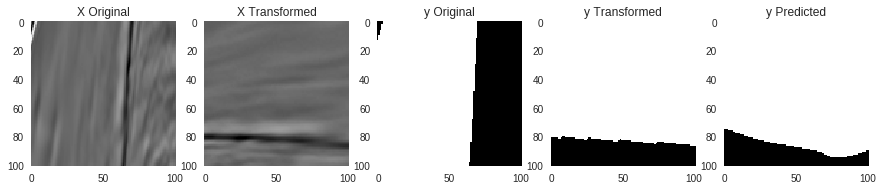

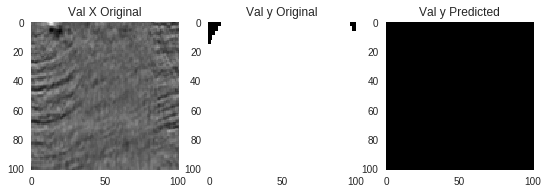

02/10/2018 01:34:41 - salt_model_v36.1_resnet_0.82_test3 - INFO - ['../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-1-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-2-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-3-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-4-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-5-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-6-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-7-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-8-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-9-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-10-Of-10']
02/10/2018 01:34:41 - salt_model_v36.1_resnet_0.82_t

/content/salt_net
remote: Counting objects: 11, done.
remote: Total 11 (delta 8), reused 8 (delta 8), pack-reused 3
Unpacking objects: 100% (11/11), done.
From https://github.com/allen-q/salt_net
   aad0fc0..7f84906  master     -> origin/master
Updating aad0fc0..7f84906
Fast-forward
 ...model_v36.2_resnet_v8_bugfix_2018_10_01_22h.log | 26 ++++++++++++++++++++++
 1 file changed, 26 insertions(+)
[master 7b34858] Pushing logs to git
 4 files changed, 278 insertions(+)
 create mode 100644 logs/SaltNet_2018_10_02_10h.log
 create mode 100644 logs/SaltNet_2018_10_02_11h.log
 create mode 100644 logs/salt_model_v36.1_resnet_0.82_test1_2018_10_02_11h.log
 create mode 100644 logs/salt_model_v36.1_resnet_0.82_test3_2018_10_02_11h.log
Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 2.96 KiB | 2.96 MiB/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local obj

02/10/2018 01:38:42 - salt_model_v36.1_resnet_0.82_test3 - INFO - Train IOU: 0.5849, Acc: 0.8731, Loss: [0.4708, 0.0886, 0.5593] at epoch 2


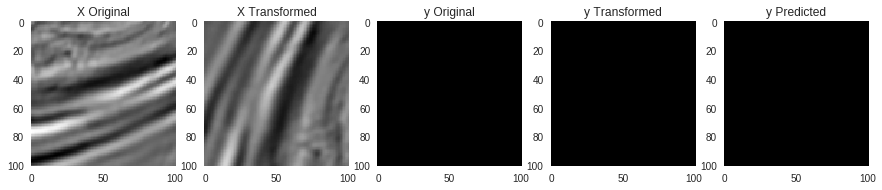

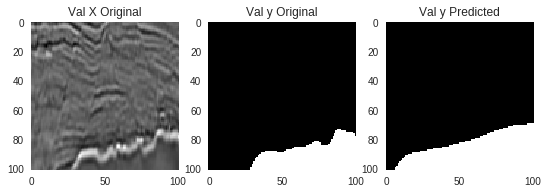

02/10/2018 01:38:57 - salt_model_v36.1_resnet_0.82_test3 - INFO - Val   IOU: 0.5594, Acc: 0.8835, Best Val IOU: 0.5786 at epoch 2
02/10/2018 01:38:57 - salt_model_v36.1_resnet_0.82_test3 - INFO - scheduler best: 0.7139649683237076 num_bad_epochs:0
02/10/2018 01:38:57 - salt_model_v36.1_resnet_0.82_test3 - INFO - None
02/10/2018 01:38:57 - salt_model_v36.1_resnet_0.82_test3 - INFO - Epoch 3/200
02/10/2018 01:38:57 - salt_model_v36.1_resnet_0.82_test3 - INFO - --------------------
02/10/2018 01:42:31 - salt_model_v36.1_resnet_0.82_test3 - INFO - Train IOU: 0.6258, Acc: 0.8933, Loss: [0.4056, 0.0788, 0.4844] at epoch 3


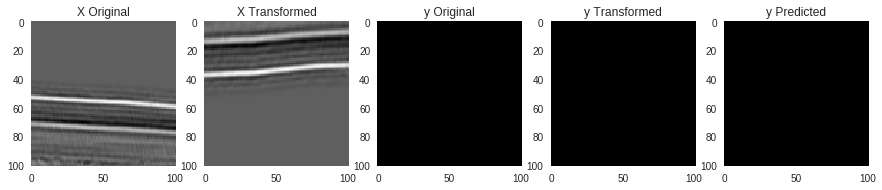

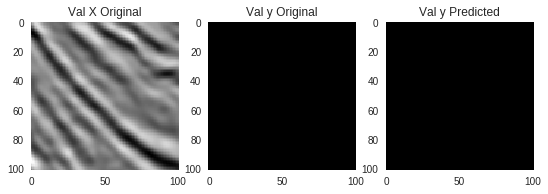

02/10/2018 01:42:49 - salt_model_v36.1_resnet_0.82_test3 - INFO - ['../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-1-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-2-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-3-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-4-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-5-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-6-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-7-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-8-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-9-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-10-Of-10']
02/10/2018 01:42:49 - salt_model_v36.1_resnet_0.82_t

/content/salt_net
From https://github.com/allen-q/salt_net
   7f84906..7b34858  master     -> origin/master
Already up-to-date.
[master e4725e0] Pushing logs to git
 1 file changed, 15 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 670 bytes | 670.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   7b34858..e4725e0  master -> master


02/10/2018 01:46:48 - salt_model_v36.1_resnet_0.82_test3 - INFO - Train IOU: 0.6378, Acc: 0.8940, Loss: [0.3966, 0.0775, 0.4741] at epoch 4


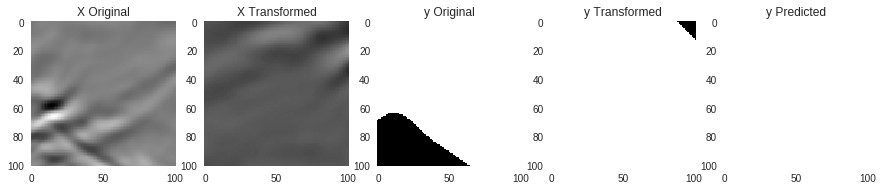

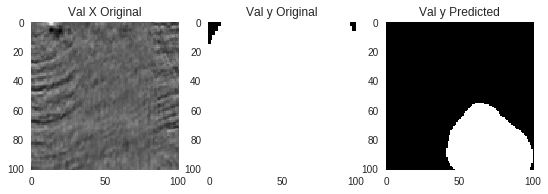

02/10/2018 01:47:06 - salt_model_v36.1_resnet_0.82_test3 - INFO - ['../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-1-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-2-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-3-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-4-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-5-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-6-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-7-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-8-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-9-Of-10', '../salt_net/salt_model_v36.3_resnet_0.82_test3_2018_10_02_11_30_49.ckp-chunk-10-Of-10']
02/10/2018 01:47:06 - salt_model_v36.1_resnet_0.82_t

In [0]:
setup_train(config_list)